# Mounting Google **Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Importing and Unzipping the Data**

In [ ]:
import zipfile
import os

# Path to your ZIP file
zip_path = '/content/extracted/EuroSAT_MS.zip'
extracted_dir = '/content/extracted'  # Extraction folder

# Make sure the extraction folder exists
os.makedirs(extracted_dir, exist_ok=True)

# Extract
try:
    print("Extracting ZIP file...")
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(extracted_dir)
    print("✅ Extraction complete!")
    print(f"Files extracted to: {extracted_dir}")

    # List extracted files (optional)
    print("\nExtracted files:")
    print(os.listdir(extracted_dir))
except zipfile.BadZipFile:
    print("❌ Error: The file is not a valid ZIP file or is corrupted")
except Exception as e:
    print(f"❌ Error: {e}")

Extracting ZIP file...
✅ Extraction complete!
Files extracted to: /content/extracted

Extracted files:
['EuroSAT_MS', 'EuroSAT_RGB', 'EuroSAT_MS.zip', 'EuroSAT_RGB.zip']


Data Extraction + Cleaning (Removing Corrupted Files)

Created clean data directory at: EuroSAT_clean

--- Processing class: PermanentCrop ---
  [Warning] Image appears blank/corrupted, skipping: PermanentCrop_2252.jpg
  [Warning] Image appears blank/corrupted, skipping: PermanentCrop_1488.jpg
--- Processing class: HerbaceousVegetation ---
  [Warning] Image appears blank/corrupted, skipping: HerbaceousVegetation_1911.jpg
  [Warning] Image appears blank/corrupted, skipping: HerbaceousVegetation_1791.jpg
  [Warning] Image appears blank/corrupted, skipping: HerbaceousVegetation_591.jpg
  [Warning] Image appears blank/corrupted, skipping: HerbaceousVegetation_2313.jpg
  [Warning] Image appears blank/corrupted, skipping: HerbaceousVegetation_1235.jpg
  [Warning] Image appears blank/corrupted, skipping: HerbaceousVegetation_2547.jpg
  [Warning] Image appears blank/corrupted, skipping: HerbaceousVegetation_187.jpg
  [Warning] Image appears blank/corrupted, skipping: HerbaceousVegetation_2541.jpg
  [Warning] Image appears blank/corrupted, skipping

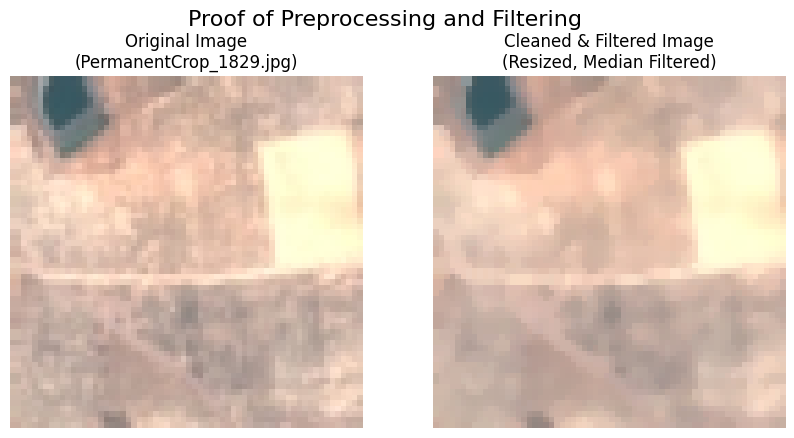

In [ ]:
import os
import cv2
import numpy as np
import shutil
from pathlib import Path
import matplotlib.pyplot as plt

# --- Configuration ---
# Path to the raw, unzipped dataset
RAW_DATA_DIR = Path("/content/extracted/EuroSAT_RGB")
# Path where the clean, processed dataset will be saved
CLEAN_DATA_DIR = Path("EuroSAT_clean")

# --- Main Preprocessing Function ---

def preprocess_dataset(raw_dir, clean_dir, target_size=(64, 64), filter_kernel_size=3):
    """
    Cleans and preprocesses the entire EuroSAT dataset.

    - Creates a new directory for the cleaned data.
    - Iterates through each class folder in the raw dataset.
    - For each image, it performs:
        1. Reading and corruption check.
        2. Conversion to RGB format.
        3. Resizing to target dimensions.
        4. Applying a median filter for noise reduction.
        5. Saving the cleaned image as a PNG file.
    """

    # Counter for tracking processed and corrupted images
    processed_count = 0
    corrupted_count = 0

    # Remove the clean directory if it already exists to start fresh
    if clean_dir.exists():
        shutil.rmtree(clean_dir)

    # Create the root directory for cleaned data
    clean_dir.mkdir(parents=True, exist_ok=True)
    print(f"Created clean data directory at: {clean_dir}\n")

    # Get class names from the folder names in the raw directory
    class_names = [d.name for d in raw_dir.iterdir() if d.is_dir()]

    # Iterate over each class
    for class_name in class_names:
        print(f"--- Processing class: {class_name} ---")
        raw_class_path = raw_dir / class_name
        clean_class_path = clean_dir / class_name
        clean_class_path.mkdir(exist_ok=True)

        # Iterate over each image in the class directory
        for image_path in raw_class_path.iterdir():
            try:
                # 1. Read the image
                img = cv2.imread(str(image_path))

                # 2. Handle corrupted or unreadable images
                if img is None:
                    print(f"  [Warning] Could not read, skipping: {image_path.name}")
                    corrupted_count += 1
                    continue

                # Check for black/blank images (low standard deviation)
                if img.std() < 10:
                    print(f"  [Warning] Image appears blank/corrupted, skipping: {image_path.name}")
                    corrupted_count += 1
                    continue

                # 3. Normalize channels: Convert to RGB (3 channels)
                if len(img.shape) == 2: # Grayscale
                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                elif img.shape[2] == 4: # 4-channel (e.g., RGBA)
                    img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR) # Convert to BGR first

                # 4. Normalize dimensions: Resize the image
                img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

                # 5. Apply Median Filter to remove noise
                img_filtered = cv2.medianBlur(img_resized, filter_kernel_size)

                # 6. Save the cleaned image in PNG format for consistency
                # PNG is lossless and avoids introducing compression artifacts.
                new_filename = image_path.stem + ".png"
                cv2.imwrite(str(clean_class_path / new_filename), img_filtered)
                processed_count += 1

            except Exception as e:
                print(f"  [Error] Failed to process {image_path.name}: {e}")
                corrupted_count += 1

    print("\n--- Preprocessing Summary ---")
    print(f"Total images successfully processed: {processed_count}")
    print(f"Total corrupted/skipped images: {corrupted_count}")


# --- Visualization Function to Show Filter Effect ---

def visualize_filter_effect(raw_dir, clean_dir):
    """
    Selects a sample image and displays a 'before and after' comparison
    to visually prove the effect of the median filter.
    """
    print("\n--- Visualizing Filter Effect ---")

    # Find a sample image to show the effect
    sample_img_path = next(raw_dir.rglob('*.tif'), None) # Find any .tif file
    if sample_img_path is None:
        sample_img_path = next(raw_dir.rglob('*.jpg'), None) # Or any .jpg

    if sample_img_path is None:
        print("Could not find a sample image to visualize.")
        return

    # Construct the path to the cleaned version of the sample image
    class_name = sample_img_path.parent.name
    cleaned_sample_path = clean_dir / class_name / (sample_img_path.stem + ".png")

    # Read both raw and cleaned images
    original_img = cv2.cvtColor(cv2.imread(str(sample_img_path)), cv2.COLOR_BGR2RGB)
    cleaned_img = cv2.cvtColor(cv2.imread(str(cleaned_sample_path)), cv2.COLOR_BGR2RGB)

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(original_img)
    axes[0].set_title(f"Original Image\n({sample_img_path.name})")
    axes[0].axis('off')

    axes[1].imshow(cleaned_img)
    axes[1].set_title(f"Cleaned & Filtered Image\n(Resized, Median Filtered)")
    axes[1].axis('off')

    plt.suptitle("Proof of Preprocessing and Filtering", fontsize=16)
    plt.show()


# --- Main Execution Block ---

if __name__ == "__main__":
    # Run the main preprocessing pipeline
    preprocess_dataset(RAW_DATA_DIR, CLEAN_DATA_DIR)

    # Show visual proof of the cleaning process
    visualize_filter_effect(RAW_DATA_DIR, CLEAN_DATA_DIR)

# **Pre-Processing**

In [ ]:
!pip install -q tifffile
import matplotlib.pyplot as plt
import tifffile as tiff
import cv2
import numpy as np
import shutil
from pathlib import Path

# --- Configuration ---
# NEW: List all your raw data directories here
RAW_DATA_DIRS = [Path("/content/extracted/EuroSAT_RGB"), Path("/content/extracted/EuroSAT_MS")]
CLEAN_DATA_DIR = Path("EuroSAT_Combined_Clean") # A single destination for all cleaned images

def preprocess_combined_datasets(raw_dirs, clean_dir, target_size=(64, 64)):
    """
    Cleans and combines multiple EuroSAT datasets (PNG and multispectral TIFF).
    """
    processed_count, corrupted_count = 0, 0

    if clean_dir.exists():
        shutil.rmtree(clean_dir)
    clean_dir.mkdir(parents=True, exist_ok=True)
    print(f"Created clean data directory at: {clean_dir}")

    # Loop through each source dataset directory
    for raw_dir in raw_dirs:
        print(f"\n--- Processing source directory: {raw_dir.name} ---")
        class_names = [d.name for d in raw_dir.iterdir() if d.is_dir()]

        for class_name in class_names:
            raw_class_path = raw_dir / class_name
            clean_class_path = clean_dir / class_name
            clean_class_path.mkdir(exist_ok=True) # Ensure class folder exists in the combined dir

            for image_path in raw_class_path.iterdir():
                try:
                    img = None
                    # --- NEW: Conditional logic based on file type ---
                    if image_path.suffix.lower() == '.tif':
                        multi_band_img = tiff.imread(str(image_path))
                        if multi_band_img is None:
                            corrupted_count += 1
                            continue
                        # Extract RGB and convert to 8-bit
                        img = multi_band_img[:, :, [3, 2, 1]]
                        p_low, p_high = np.percentile(img, (2, 98))
                        img = np.clip(img, p_low, p_high)
                        img = ((img - p_low) / (p_high - p_low)) * 255.0
                        img = img.astype(np.uint8)

                    elif image_path.suffix.lower() in ['.png', '.jpg', '.jpeg']:
                        img = cv2.imread(str(image_path))
                        if img is None or img.std() < 10:
                            corrupted_count += 1
                            continue
                        # Standardize channels if needed
                        if len(img.shape) == 2: img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                        elif img.shape[2] == 4: img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)

                    else:
                        corrupted_count += 1
                        continue # Skip unsupported file types

                    # --- Standard processing for all images ---
                    img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
                    img_filtered = cv2.medianBlur(img_resized, 3)

                    # Create a unique name to avoid conflicts and save as PNG
                    new_filename = f"{raw_dir.name}_{image_path.stem}.png"
                    cv2.imwrite(str(clean_class_path / new_filename), img_filtered)
                    processed_count += 1

                except Exception as e:
                    corrupted_count += 1

    print(f"\nPreprocessing complete. Processed: {processed_count}, Skipped: {corrupted_count}")


# --- Main Execution ---
if __name__ == "__main__":
    # IMPORTANT: Update the paths in the RAW_DATA_DIRS list above before running
    preprocess_combined_datasets(RAW_DATA_DIRS, CLEAN_DATA_DIR)

Created clean data directory at: EuroSAT_Combined_Clean

--- Processing source directory: EuroSAT_RGB ---

--- Processing source directory: EuroSAT_MS ---

Preprocessing complete. Processed: 53516, Skipped: 484


In [ ]:
from sklearn.manifold import TSNE
import random
from tqdm import tqdm

# --- Configuration ---
RAW_DATA_DIR = Path("/content/extracted/EuroSAT_RGB")
CLEAN_DATA_DIR = Path("/content/EuroSAT_Combined_Clean")
NUM_SAMPLES_FOR_TSNE = 200 # Number of images to sample from each class for t-SNE

# --- Part 1: Color Histogram Comparison ---

def calculate_average_histogram(directory_path, class_name):
    """Calculates the average BGR histogram for all images of a specific class."""
    class_path = directory_path / class_name
    hist = np.zeros((256, 3)) # B, G, R channels

    image_files = list(class_path.glob('*.png')) + list(class_path.glob('*.jpg')) + list(class_path.glob('*.tif'))

    # This is the section with the change
    if not image_files:
        print(f"No images found for class {class_name} in {directory_path}")
        return hist # CHANGED: Now only returns the histogram array

    for img_path in tqdm(image_files, desc=f"Histogram for {class_name} in {directory_path.name}"):
        img = cv2.imread(str(img_path))
        if img is not None:
            for i in range(3):
                channel_hist = cv2.calcHist([img], [i], None, [256], [0, 256])
                hist[:, i] += channel_hist.flatten()

    hist /= len(image_files)
    return hist

def plot_histogram_comparison(raw_hist, clean_hist, class_name):
    """Plots the raw vs. clean histograms for comparison."""
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
    colors = ('b', 'g', 'r')

    # Plot for Raw Data
    axes[0].set_title(f'Raw Data - Avg. Histogram for "{class_name}"')
    axes[0].set_xlabel('Pixel Intensity')
    axes[0].set_ylabel('Average Frequency')
    for i, color in enumerate(colors):
        axes[0].plot(raw_hist[:, i], color=color, alpha=0.7, label=f'{color.upper()} channel')
    axes[0].legend()
    axes[0].set_xlim([0, 256])

    # Plot for Cleaned Data
    axes[1].set_title(f'Cleaned Data - Avg. Histogram for "{class_name}"')
    axes[1].set_xlabel('Pixel Intensity')
    for i, color in enumerate(colors):
        axes[1].plot(clean_hist[:, i], color=color, alpha=0.7, label=f'{color.upper()} channel')
    axes[1].legend()
    axes[1].set_xlim([0, 256])

    plt.suptitle(f'Feature Visualization: Color Histogram Comparison', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
# --- Part 2: t-SNE for Class Separability ---

def prepare_data_for_tsne(data_dir, classes, num_samples):
    """Extracts features (flattened histograms) and labels for t-SNE."""
    features = []
    labels = []

    for i, class_name in enumerate(classes):
        class_path = data_dir / class_name
        image_files = list(class_path.glob('*.png')) + list(class_path.glob('*.jpg')) + list(class_path.glob('*.tif'))

        # Take a random sample of images from the class
        sampled_files = random.sample(image_files, min(num_samples, len(image_files)))

        for img_path in tqdm(sampled_files, desc=f"t-SNE features for {class_name} in {data_dir.name}"):
            img = cv2.imread(str(img_path))
            if img is not None:
                # Use a smaller histogram for faster t-SNE processing
                hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
                features.append(hist.flatten())
                labels.append(i) # Use numeric index for label

    return np.array(features), np.array(labels)

def plot_tsne_comparison(tsne_raw, tsne_clean, labels_raw, labels_clean, classes):
    """Plots the raw vs. clean t-SNE results for comparison."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    colors = plt.cm.get_cmap('tab10', len(classes))

    # Plot for Raw Data
    axes[0].set_title('t-SNE of Raw Data Features')
    for i, class_name in enumerate(classes):
        indices = (labels_raw == i)
        axes[0].scatter(tsne_raw[indices, 0], tsne_raw[indices, 1], c=[colors(i)], label=class_name, alpha=0.7)
    axes[0].legend()
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    # Plot for Cleaned Data
    axes[1].set_title('t-SNE of Cleaned Data Features')
    for i, class_name in enumerate(classes):
        indices = (labels_clean == i)
        axes[1].scatter(tsne_clean[indices, 0], tsne_clean[indices, 1], c=[colors(i)], label=class_name, alpha=0.7)
    axes[1].legend()
    axes[1].set_xticks([])
    axes[1].set_yticks([])

    plt.suptitle('Feature Visualization: t-SNE for Class Separability', fontsize=16)
    plt.show()

--- Part 1: Generating Color Histogram Comparison ---


Histogram for SeaLake in EuroSAT_Combined_Clean: 100%|██████████| 5865/5865 [00:02<00:00, 2203.11it/s]


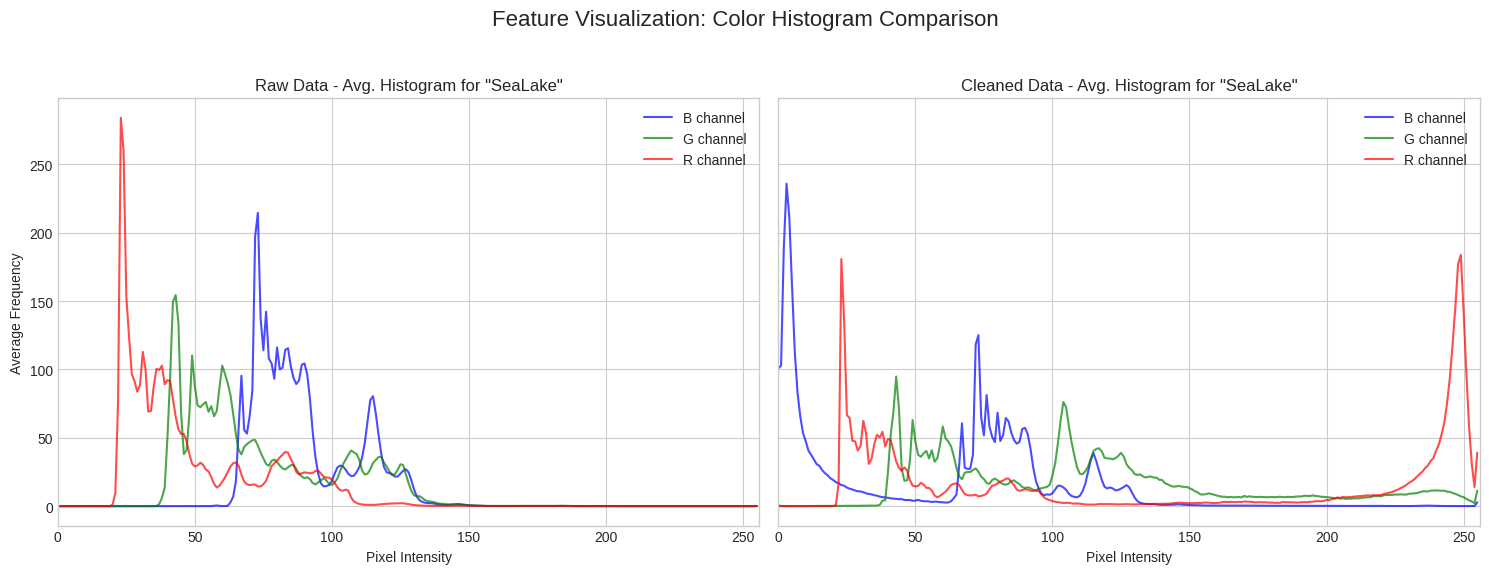


--- Part 2: Generating t-SNE Separability Comparison ---


t-SNE features for River in EuroSAT_RGB: 100%|██████████| 200/200 [00:00<00:00, 8331.54it/s]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 600 samples in 0.001s...
[t-SNE] Computed neighbors for 600 samples in 0.030s...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 550.802184



/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.789150
[t-SNE] KL divergence after 300 iterations: 0.489173


t-SNE features for Forest in EuroSAT_Combined_Clean: 100%|██████████| 200/200 [00:00<00:00, 1574.73it/s]
t-SNE features for Residential in EuroSAT_Combined_Clean: 100%|██████████| 200/200 [00:00<00:00, 1197.63it/s]
t-SNE features for River in EuroSAT_Combined_Clean: 100%|██████████| 200/200 [00:00<00:00, 1220.68it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 600 samples in 0.001s...
[t-SNE] Computed neighbors for 600 samples in 0.033s...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 785.310977
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.369640
[t-SNE] KL divergence after 300 iterations: 0.492577


/tmp/ipython-input-3691194368.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(classes))


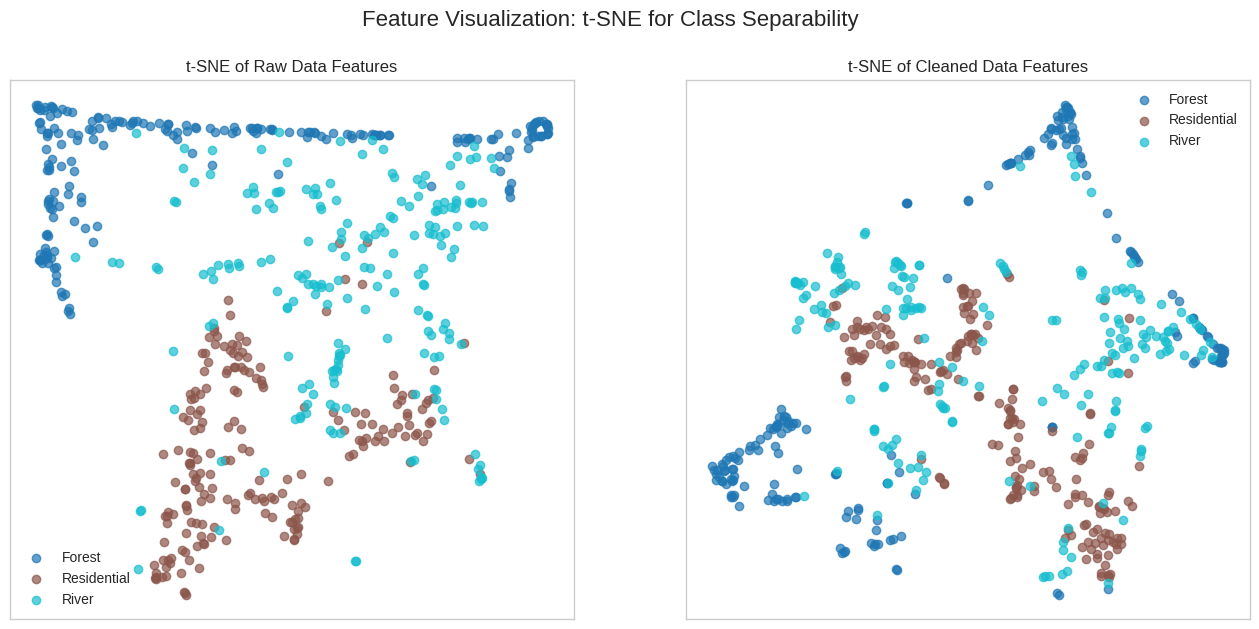

In [ ]:
# --- Main Execution ---
if __name__ == "__main__":
    # Part 1: Generate and plot histogram comparison
    print("--- Part 1: Generating Color Histogram Comparison ---")
    hist_class = 'SeaLake'
    avg_hist_raw = calculate_average_histogram(RAW_DATA_DIR, hist_class)
    avg_hist_clean = calculate_average_histogram(CLEAN_DATA_DIR, hist_class)
    plot_histogram_comparison(avg_hist_raw, avg_hist_clean, hist_class)

    # Part 2: Generate and plot t-SNE comparison
    print("\n--- Part 2: Generating t-SNE Separability Comparison ---")
    tsne_classes = ['Forest', 'Residential', 'River']

    # Process raw data for t-SNE
    features_raw, labels_raw = prepare_data_for_tsne(RAW_DATA_DIR, tsne_classes, NUM_SAMPLES_FOR_TSNE)
    tsne_model_raw = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results_raw = tsne_model_raw.fit_transform(features_raw)

    # Process clean data for t-SNE
    features_clean, labels_clean = prepare_data_for_tsne(CLEAN_DATA_DIR, tsne_classes, NUM_SAMPLES_FOR_TSNE)
    tsne_model_clean = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results_clean = tsne_model_clean.fit_transform(features_clean)

    # Plot the comparison
    plot_tsne_comparison(tsne_results_raw, tsne_results_clean, labels_raw, labels_clean, tsne_classes)

# Data Processing for Model

Baseline Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# --- Configuration ---
CLEAN_DATA_DIR = Path("/content/EuroSAT_clean")
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
EPOCHS = 15 # We can adjust this later if needed

# --- 1. Load Data and Create Datasets ---
print("--- Loading and preparing data ---")

# Create the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    CLEAN_DATA_DIR,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Create the validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    CLEAN_DATA_DIR,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Get class names
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Found {num_classes} classes: {class_names}")

# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

--- Loading and preparing data ---
Found 26516 files belonging to 10 classes.
Using 21213 files for training.
Found 26516 files belonging to 10 classes.
Using 5303 files for validation.
Found 10 classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']



--- Building and training the baseline model ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,194,122 (8.37 MB)

 Trainable params: 2,193,674 (8.37 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/15
663/663 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.4476 - loss: 1.9839 - val_accuracy: 0.4179 - val_loss: 1.8200
Epoch 2/15
663/663 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.5931 - loss: 1.1450 - val_accuracy: 0.4724 - val_loss: 1.7098
Epoch 3/15
663/663 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6612 - loss: 0.9792 - val_accuracy: 0.6172 - val_loss: 1.0440
Epoch 4/15
663/663 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6965 - loss: 0.8683 - val_accuracy: 0.5538 - val_loss: 1.6861
Epoch 5/15
663/663 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7376 - loss: 0.7393 - val_accuracy: 0.5983 - val_loss: 1.3065
Epoch 6/15
663/663 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7619 - loss: 0.6953 - val_accuracy: 0.6338 - val_loss: 1.0123
Epoch 7/15
663/663 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8021 - loss: 0.5747 - val_accuracy: 0.7649 - val_loss: 0.8471
Epoch 8/15
663/663 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8235 - loss: 0.5170 - val_accurac

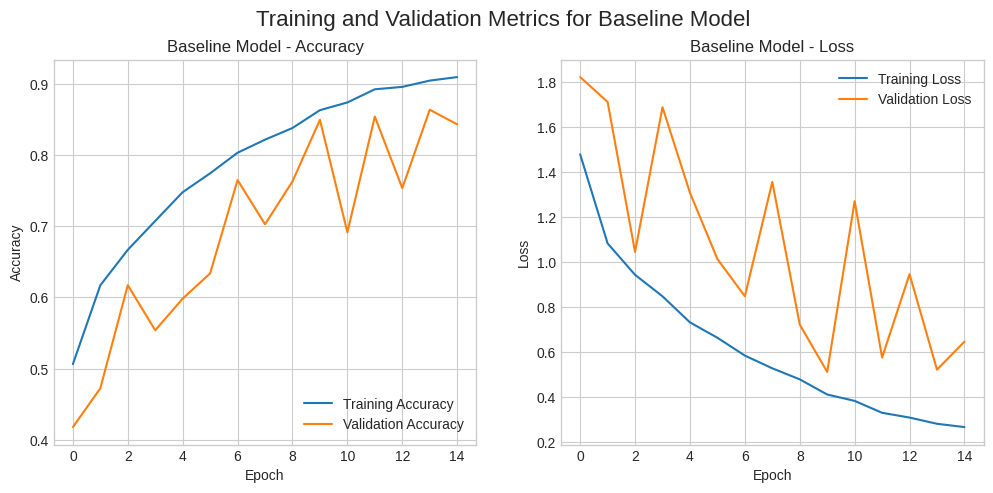

In [ ]:
# --- 2. Build the Baseline CNN Model ---
def build_baseline_model(input_shape, num_classes):
    """Builds a CNN model based on the project requirements."""
    model = models.Sequential([
        # Input layer: Rescale pixel values from [0, 255] to [0, 1]
        layers.Input(shape=input_shape),
        layers.Rescaling(1./255),

        # Conv Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'), #
        layers.BatchNormalization(), #
        layers.MaxPooling2D((2, 2)), #

        # Conv Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'), #
        layers.BatchNormalization(), #
        layers.MaxPooling2D((2, 2)), #

        # Conv Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'), #
        layers.BatchNormalization(), #
        layers.MaxPooling2D((2, 2)), #

        # Classifier Head
        layers.Flatten(),
        layers.Dense(256, activation='relu'), #
        layers.Dropout(0.5), #
        layers.Dense(num_classes, activation='softmax') #
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# --- 3. Train the Model ---
print("\n--- Building and training the baseline model ---")
baseline_model = build_baseline_model(IMG_SIZE + (3,), num_classes)
baseline_model.summary()

history = baseline_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

# --- 4. Visualize Training Results ---
def plot_history(history, model_name):
    """Plots training and validation accuracy/loss curves."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.suptitle(f'Training and Validation Metrics for {model_name}', fontsize=16)
    plt.show()

print("\n--- Plotting training history ---")
plot_history(history, "Baseline Model")

**Improved Model**

Found 26516 files belonging to 10 classes.
Using 21213 files for training.
Found 26516 files belonging to 10 classes.
Using 5303 files for validation.

--- Building and training the improved model ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,194,122 (8.37 MB)

 Trainable params: 2,193,674 (8.37 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/25
663/663 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.5076 - loss: 1.5051 - val_accuracy: 0.6949 - val_loss: 0.8671 - learning_rate: 1.0000e-04
Epoch 2/25
663/663 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6614 - loss: 0.9789 - val_accuracy: 0.7124 - val_loss: 0.8138 - learning_rate: 1.0000e-04
Epoch 3/25
663/663 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6911 - loss: 0.8741 - val_accuracy: 0.7724 - val_loss: 0.6699 - learning_rate: 1.0000e-04
Epoch 4/25
663/663 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7257 - loss: 0.8003 - val_accuracy: 0.7845 - val_loss: 0.5859 - learning_rate: 1.0000e-04
Epoch 5/25
663/663 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7413 - loss: 0.7422 - val_accuracy: 0.7918 - val_loss: 0.5747 - learning_rate: 1.0000e-04
Epoch 6/25
663/663 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7510 - loss: 0.7192 - val_accuracy: 0.7879 - val_loss: 0.6151 - learning_rate: 1.0000e-04
Epoch 7/25
663/663 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/ste

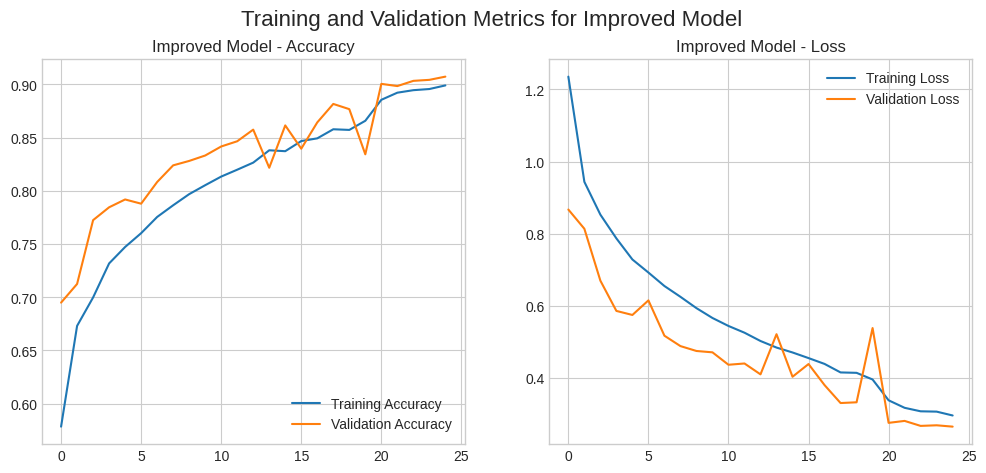

In [ ]:
import tensorflow as tf
from tensorflow.keras import callbacks

# --- 1. Configuration and Data Loading (Same as before) ---
CLEAN_DATA_DIR = Path("/content/EuroSAT_clean")
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
EPOCHS = 25 # We can set a higher epoch limit since EarlyStopping will stop it for us

# Load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    CLEAN_DATA_DIR,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    CLEAN_DATA_DIR,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
num_classes = len(class_names)

# Optimize datasets
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# --- 2. Build the Improved CNN Model ---

# NEW: Define the data augmentation layer
data_augmentation = models.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
    ],
    name="data_augmentation",
)

def build_improved_model(input_shape, num_classes):
    """Builds the improved CNN with data augmentation and a lower learning rate."""
    model = models.Sequential([
        layers.Input(shape=input_shape),
        data_augmentation,
        layers.Rescaling(1./255),

        # Conv Blocks
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    # --- CHANGED LINE ---
    # Instead of the default Adam, we specify one with a lower learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# --- 3. Define Callbacks and Train the Model ---

# NEW: Define the callbacks for performance improvement
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',      # Monitor validation loss
    patience=5,              # Stop after 5 epochs with no improvement
    restore_best_weights=True # Restore the best model weights
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', # Monitor validation loss
    factor=0.2,         # Reduce LR by a factor of 5
    patience=2          # Reduce if no improvement for 2 epochs
)

print("\n--- Building and training the improved model ---")
improved_model = build_improved_model(IMG_SIZE + (3,), num_classes)
improved_model.summary()

# Train with the new callbacks
history_improved = improved_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr] # Pass the callbacks here
)


# --- 4. Visualize Training Results (Using the same function as before) ---
def plot_history(history, model_name):
    """Plots training and validation accuracy/loss curves."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - Loss')

    plt.suptitle(f'Training and Validation Metrics for {model_name}', fontsize=16)
    plt.show()

print("\n--- Plotting training history for Improved Model ---")
plot_history(history_improved, "Improved Model")

# **Evaluation For Improved Model**

--- Evaluating the Improved Model ---
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

--- Classification Report ---
                      precision    recall  f1-score   support

          AnnualCrop       0.91      0.83      0.87       552
              Forest       0.95      0.97      0.96       617
HerbaceousVegetation       0.87      0.78      0.82       529
             Highway       0.74      0.71      0.72       491
          Industrial       0.91      0.96      0.94       486
             Pasture       0.83      0.90      0.86       395
       PermanentCrop       0.80      0.76      0.78       533
         Residential       0.82      0.99      0.90       627
               River       0.87      0.83      0.85       508
             SeaLake       0.99      0.94      0.97       565

            accuracy                           0.87      5303
           macro avg       0.87      0.87      0.87      5303
        weighted avg       0.87      0.87      0.87      5303


--- Generating Con

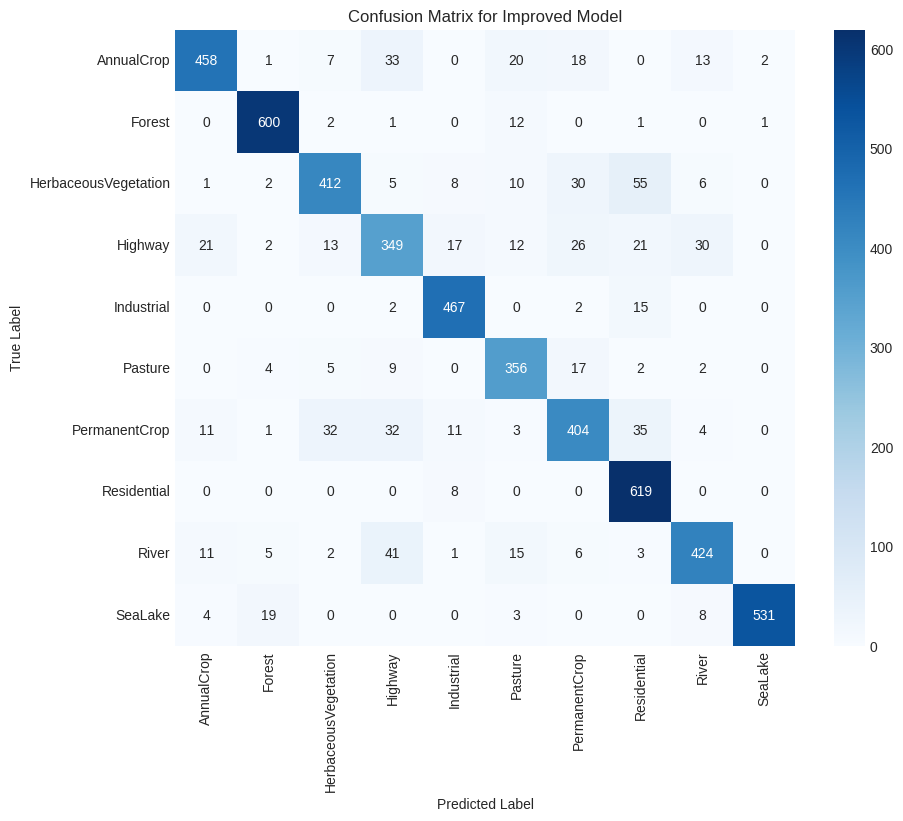


--- Saving predictions to predictions.csv ---
Found 53516 files belonging to 10 classes.
Using 10703 files for validation.
335/335 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step

Successfully saved 10703 predictions to 'predictions.csv'.
Top 5 rows of the CSV:
                    image_id predicted_label
0  EuroSAT_MS_River_1144.png           River
1  EuroSAT_MS_River_1145.png           River
2  EuroSAT_MS_River_1146.png      AnnualCrop
3  EuroSAT_MS_River_1147.png           River
4  EuroSAT_MS_River_1148.png           River


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix

# --- Configuration (ensure these match your training script) ---
CLEAN_DATA_DIR = Path("//content/EuroSAT_Combined_Clean")
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

# --- NOTE: This script assumes 'improved_model', 'val_ds', and 'class_names' ---
# --- are already loaded in your environment from the previous training step. ---

# --- 1. Get Predictions and True Labels ---
print("--- Evaluating the Improved Model ---")

# Extract true labels from the validation dataset
true_labels = np.concatenate([y for x, y in val_ds], axis=0)

# Make predictions on the validation dataset
predictions = improved_model.predict(val_ds)
predicted_labels = np.argmax(predictions, axis=1)


# --- 2. Generate Classification Report and Confusion Matrix ---

# Print the classification report
print("\n--- Classification Report ---")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Compute and plot the confusion matrix
print("\n--- Generating Confusion Matrix ---")
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Improved Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


# --- 3. Save Predictions to CSV File (Corrected) ---
print("\n--- Saving predictions to predictions.csv ---")

# Re-create the validation dataset temporarily to access its file paths
# Create validation dataset without shuffle
val_ds_noshuffle = tf.keras.utils.image_dataset_from_directory(
    CLEAN_DATA_DIR,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Get predictions and labels from the same dataset
predictions = improved_model.predict(val_ds_noshuffle)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.concatenate([y.numpy() for _, y in val_ds_noshuffle], axis=0)

# Save CSV
df = pd.DataFrame({
    'image_id': [Path(fp).name for fp in val_ds_noshuffle.file_paths],
    'predicted_label': [class_names[i] for i in predicted_labels]
})
df.to_csv('predictions.csv', index=False)

print(f"\nSuccessfully saved {len(df)} predictions to 'predictions.csv'.")
print("Top 5 rows of the CSV:")
print(df.head())

# **Evaluation for the Baseline Model**

--- Evaluating the Improved Model ---
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

--- Classification Report ---
                      precision    recall  f1-score   support

          AnnualCrop       0.95      0.84      0.89       552
              Forest       0.93      0.98      0.95       617
HerbaceousVegetation       0.46      0.98      0.63       529
             Highway       0.96      0.83      0.89       491
          Industrial       0.99      0.97      0.98       486
             Pasture       0.99      0.66      0.79       395
       PermanentCrop       0.94      0.63      0.76       533
         Residential       1.00      0.66      0.79       627
               River       0.87      0.93      0.90       508
             SeaLake       0.97      0.97      0.97       565

            accuracy                           0.85      5303
           macro avg       0.91      0.85      0.86      5303
        weighted avg       0.91      0.85      0.86      5303


--- Generating Con

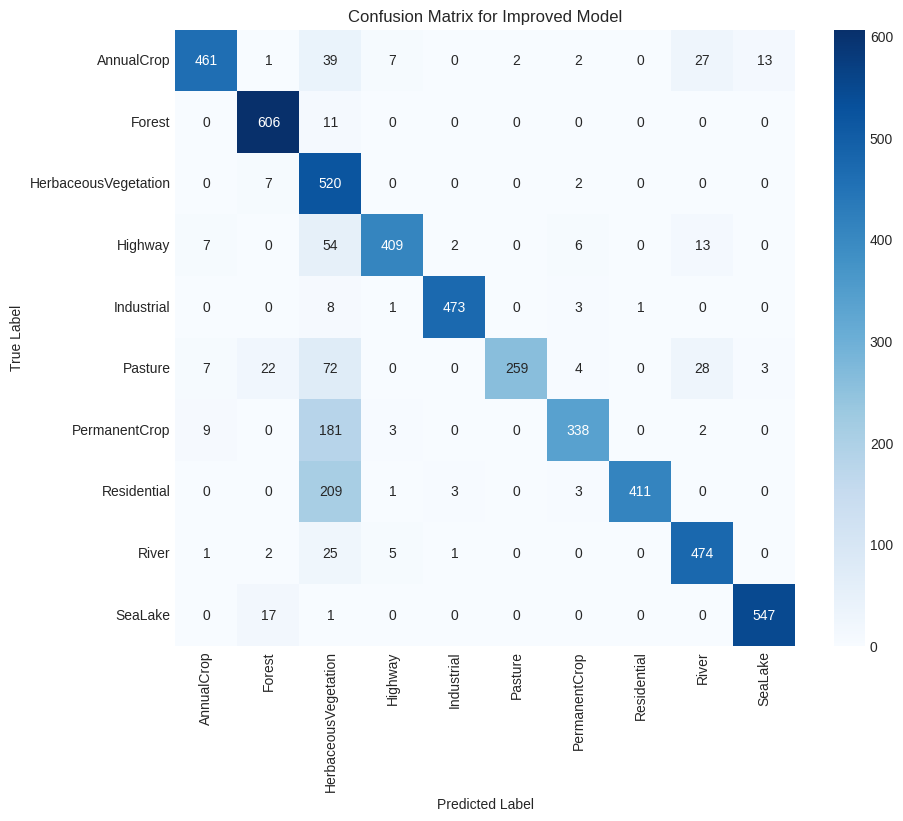


--- Saving predictions to predictions.csv ---
Found 53516 files belonging to 10 classes.
Using 10703 files for validation.
335/335 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

Successfully saved 10703 predictions to 'predictions.csv'.
Top 5 rows of the CSV:
                    image_id predicted_label
0  EuroSAT_MS_River_1144.png           River
1  EuroSAT_MS_River_1145.png           River
2  EuroSAT_MS_River_1146.png           River
3  EuroSAT_MS_River_1147.png           River
4  EuroSAT_MS_River_1148.png           River


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix

# --- Configuration (ensure these match your training script) ---
CLEAN_DATA_DIR = Path("/content/EuroSAT_Combined_Clean")
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

# --- NOTE: This script assumes 'improved_model', 'val_ds', and 'class_names' ---
# --- are already loaded in your environment from the previous training step. ---

# --- 1. Get Predictions and True Labels ---
print("--- Evaluating the Improved Model ---")

# Extract true labels from the validation dataset
true_labels = np.concatenate([y for x, y in val_ds], axis=0)

# Make predictions on the validation dataset
predictions = baseline_model.predict(val_ds)
predicted_labels = np.argmax(predictions, axis=1)


# --- 2. Generate Classification Report and Confusion Matrix ---

# Print the classification report
print("\n--- Classification Report ---")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Compute and plot the confusion matrix
print("\n--- Generating Confusion Matrix ---")
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Improved Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


# --- 3. Save Predictions to CSV File (Corrected) ---
print("\n--- Saving predictions to predictions.csv ---")

# Re-create the validation dataset temporarily to access its file paths
# Create validation dataset without shuffle
val_ds_noshuffle = tf.keras.utils.image_dataset_from_directory(
    CLEAN_DATA_DIR,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Get predictions and labels from the same dataset
predictions = baseline_model.predict(val_ds_noshuffle)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.concatenate([y.numpy() for _, y in val_ds_noshuffle], axis=0)

# Save CSV
df = pd.DataFrame({
    'image_id': [Path(fp).name for fp in val_ds_noshuffle.file_paths],
    'predicted_label': [class_names[i] for i in predicted_labels]
})
df.to_csv('predictions.csv', index=False)

print(f"\nSuccessfully saved {len(df)} predictions to 'predictions.csv'.")
print("Top 5 rows of the CSV:")
print(df.head())

# **Saving Models**

In [ ]:
# --- NOTE: This assumes your models, 'baseline_model' and 'improved_model', ---
# --- are trained and exist in your current session. ---

# Define the filenames for the saved models
baseline_model_path = '/content/drive/Shareddrives/ML_LoopVerse/baseline_model.keras'
improved_model_path = '/content/drive/Shareddrives/ML_LoopVerse/improved_model.keras'

# Save the baseline model
print(f"Saving baseline model to: {baseline_model_path}")
baseline_model.save(baseline_model_path)
print("Baseline model saved successfully.")

# Save the improved model
print(f"\nSaving improved model to: {improved_model_path}")
improved_model.save(improved_model_path)
print("Improved model saved successfully.")



# --- NOTE: This assumes your models are trained and in the current session. ---

# Define the filenames for the saved HDF5 models
baseline_model_h5_path = '/content/drive/Shareddrives/ML_LoopVerse/baseline_model.h5'
improved_model_h5_path = '/content/drive/Shareddrives/ML_LoopVerse/improved_model.h5'

# Save the baseline model in HDF5 format
print(f"Saving baseline model to: {baseline_model_h5_path}")
baseline_model.save(baseline_model_h5_path)
print("Baseline model saved successfully.")

# Save the improved model in HDF5 format
print(f"\nSaving improved model to: {improved_model_h5_path}")
improved_model.save(improved_model_h5_path)
print("Improved model saved successfully.")

# **Importing Models**

In [ ]:
from tensorflow import keras

# Path to your model in Google Drive
model_path = '/content/drive/Shareddrives/ML_LoopVerse/improved_model.keras'

# Load the model
improved_model = keras.models.load_model(model_path)

# Check that it loaded
improved_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,581,472 (25.11 MB)

 Trainable params: 2,193,674 (8.37 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 4,387,350 (16.74 MB)

In [ ]:
from tensorflow import keras

# Path to your model in Google Drive
model_path = '/content/drive/Shareddrives/ML_LoopVerse/baseline_model.keras'

# Load the model
baseline_model = keras.models.load_model(model_path)

# Check that it loaded
baseline_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,581,472 (25.11 MB)

 Trainable params: 2,193,674 (8.37 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 4,387,350 (16.74 MB)

# **Evaluation on one Image**

In [ ]:
import numpy as np
import tensorflow as tf

import tensorflow as tf
from pathlib import Path

# Path to your dataset
CLEAN_DATA_DIR = Path("/content/EuroSAT_clean")

IMG_SIZE = (64, 64)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

# Create a small dataset just to get class names
temp_ds = tf.keras.utils.image_dataset_from_directory(
    CLEAN_DATA_DIR,
    validation_split=VALIDATION_SPLIT,
    subset="training",  # can be "training" or "validation" – class names will be the same
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = temp_ds.class_names
print("Class names:", class_names)


# Ensure 'improved_model' and 'class_names' are loaded from your training session

def predict_single_image(model, image_path, img_size=(64, 64)):
    """Loads, preprocesses, and predicts a single image."""

    # 1. Load the image from the path and resize it
    img = tf.keras.utils.load_img(
        image_path, target_size=img_size
    )

    # 2. Convert the image to a NumPy array
    img_array = tf.keras.utils.img_to_array(img)

    # 3. Add a "batch" dimension to the array
    # The model expects a shape of (1, 64, 64, 3), not (64, 64, 3)
    img_array = np.expand_dims(img_array, axis=0)

    # 4. Make the prediction
    predictions = model.predict(img_array)

    # 5. Get the class with the highest probability
    predicted_class_index = np.argmax(predictions[0])
    predicted_class_name = class_names[predicted_class_index]
    confidence = 100 * np.max(predictions[0])

    return predicted_class_name, confidence

# --- Example Usage ---
image_to_predict = '/content/extracted/EuroSAT_RGB/HerbaceousVegetation/HerbaceousVegetation_1181.jpg'
predicted_label, confidence_score = predict_single_image(improved_model, image_to_predict)

print(f"Image: {image_to_predict}")
print(f"Predicted Label: {predicted_label}")
print(f"Confidence: {confidence_score:.2f}%")

Found 26516 files belonging to 10 classes.
Using 21213 files for training.
Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
Image: /content/extracted/EuroSAT_RGB/HerbaceousVegetation/HerbaceousVegetation_1181.jpg
Predicted Label: HerbaceousVegetation
Confidence: 99.98%
